In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import tensorflow as tf
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, sys, random

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> Directory setting

In [2]:
mother_dir = "/kaggle/input/medsam-open-dataset-with-validation-set"

cxr_dir = '/kaggle/input/medsam-open-dataset-with-validation-set/NIH_CXR_TFREC/data'
mr_mother_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR"

endo_chole_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/CholecSeg8k/CholecSeg8k"
endo_kvasir_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/Kvasir-SEG/Kvasir-SEG"

mr_totalseg_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/MR_totalseg_mr/totalseg_mr"
mammo_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/Mammography/Mammography/CDD-CESM"
##########################
validation_image_dir = '/kaggle/input/medsam-open-dataset-with-validation-set/imgs/imgs'
validation_gt_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/gts"

In [3]:
mri_dir = [os.path.join(mr_mother_dir, path) for path in os.listdir(mr_mother_dir)]
mri_dir = mri_dir + [mr_totalseg_dir]

# Exploring NPZ file format
- MR 등 multi frame: [n_of_frame, H, W]
- single frame data : [H,W,3] 등

> npz file을 load, imgs 키에 이미지 텐서가 있음

In [4]:
def get_image_from_npz(npz_file):
    return tf.convert_to_tensor(np.load(npz_file)["imgs"])
    
def merge_tensor(dirs, res = 384, shuffle = True):
    output = []
    for d in tqdm(dirs):
        # [N, H, W] or [H,W,3]
        tensor = get_image_from_npz(d)
        if tensor.shape[-1] != 3:
            tensor = tensor[..., tf.newaxis]
            tensor = tf.image.grayscale_to_rgb(tensor)
            tensor = tf.image.rot90(tensor, 2)
        else:
            tensor = tensor[tf.newaxis, ...]
        # now tensor shape : [N. H, W, 3] or [H, W, 3]
        tensor = tf.image.resize_with_pad(
                                            tensor,
                                            res,
                                            res,
                                            antialias=True
                                        )
        tensor = np.array(tensor).astype("uint8")
        output.append(tensor) ; del tensor
    output = np.concatenate(output, axis = 0)
    if shuffle:
        np.random.shuffle(output)
    return output

100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


(1582, 384, 384, 3) uint8


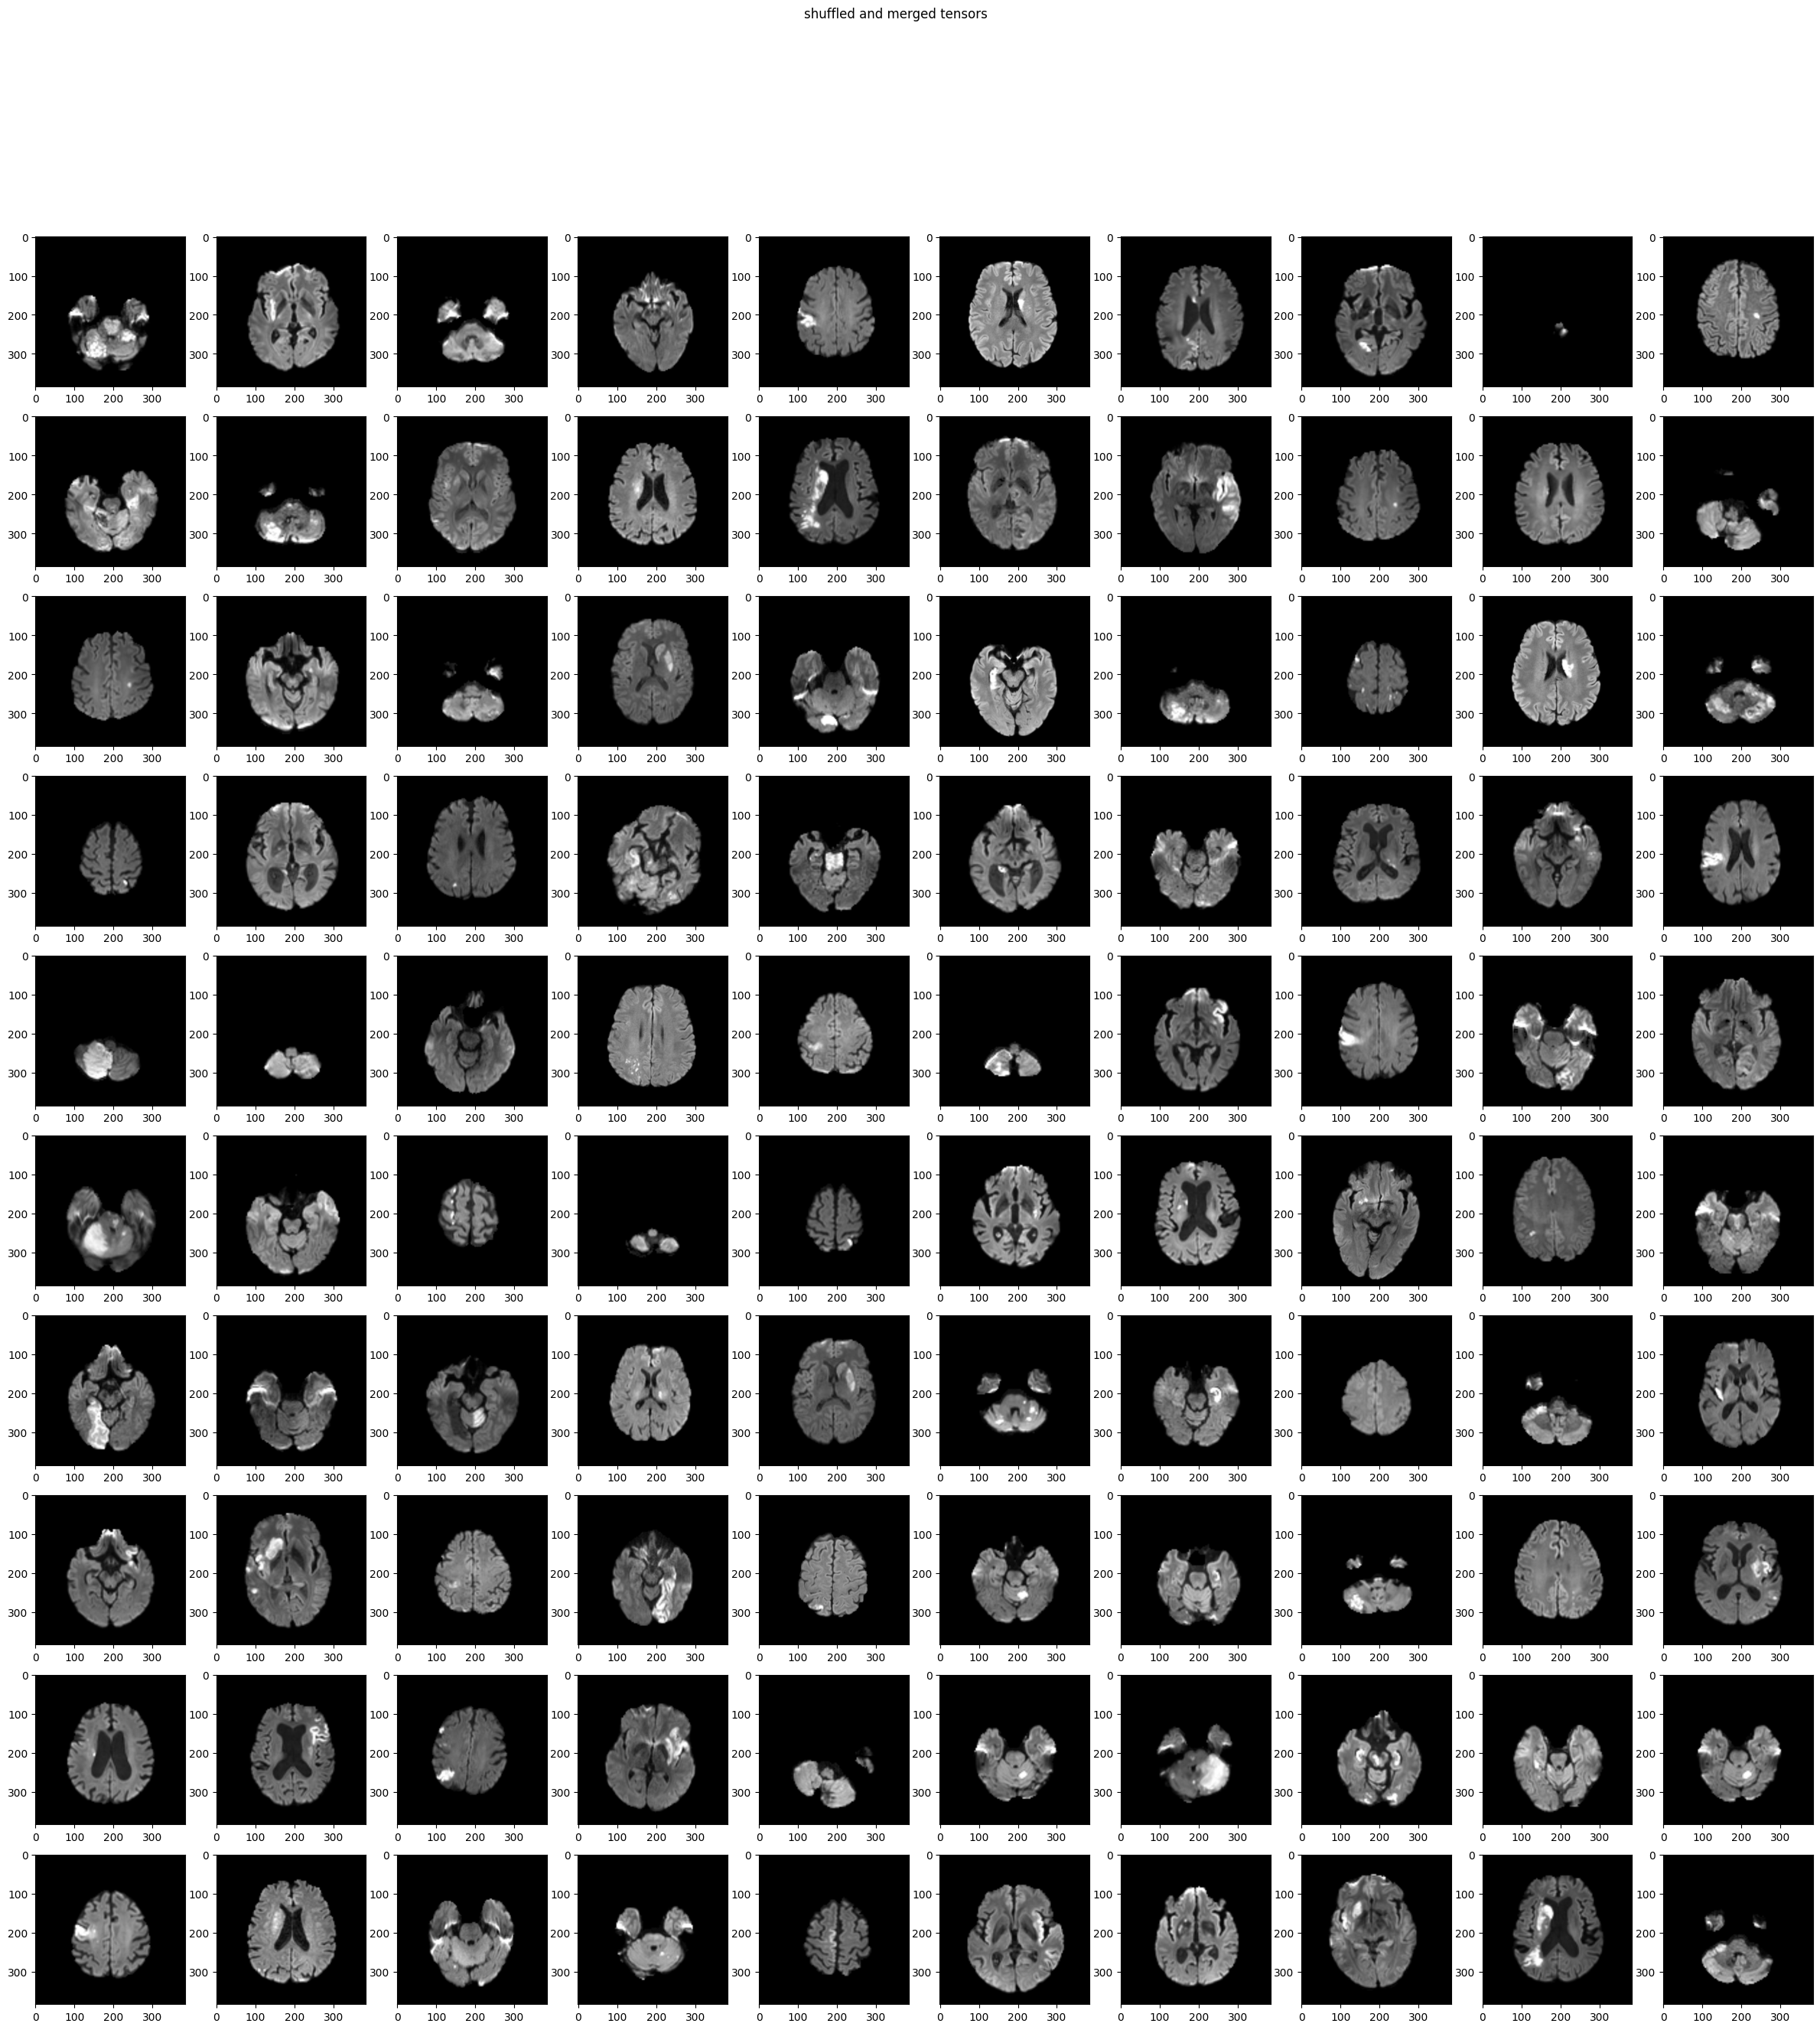

In [5]:
mr_dir_ = '/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/ISLES2022_DWI'
mr_files_ = [os.path.join(mr_dir_, d) for d in tqdm(os.listdir(mr_dir_))][:100]
tensors_ = merge_tensor(mr_files_)
print(tensors_.shape, tensors_.dtype)
fig, axes = plt.subplots(10, 10, figsize = (30,30))
axes = axes.flatten()
for t, ax in zip(tensors_, axes):
    ax.imshow(tf.cast(t, "uint8"))
plt.suptitle("shuffled and merged tensors")
plt.show()

# image (and bounding box) visualization

In [6]:
def visualize_image(img, bbox=None, label=None, figsize=(10, 8)):
  """
  이미지와 바운딩 박스를 시각화하는 함수

  Args:
    img: 이미지 텐서, shape은 [h, w, channel]
    bbox: 바운딩 박스 텐서, shape은 [number_of_boxes, 4] 또는 [number_of_boxes, 5]
    label: (Optional) 클래스 라벨
    figsize: 출력 이미지 크기

  Returns:
    None
  """

  # 이미지 출력 준비
  plt.figure(figsize=figsize)
  plt.imshow(img, cmap='gray' if img.shape[-1] == 1 else 'brg')  # 채널에 따라 컬러맵 조정

  # bbox가 존재할 경우에만 바운딩 박스 표시
  if bbox is not None:
    # 색깔 팔레트 생성
    colors = matplotlib.colormaps.get_cmap('hsv')

    # 바운딩 박스 표시
    for i in range(len(bbox)):
      box = bbox[i]
      xmin, ymin, xmax, ymax = box[:4]
      color = colors(i)

      # 바운딩 박스 그리기
      rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=2)
      plt.gca().add_patch(rect)

      # 라벨 표시 (선택적)
      if label is not None:
        plt.text(xmin, ymin - 2, f'{label[i]}', fontsize=12, color='white', bbox=dict(facecolor=color, alpha=0.5))

  plt.show()

In [7]:
#tfr 작성
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def make_example(img):
    feature = {'image': _bytes_feature(img.tobytes()), #image
               } #integer classifier
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [8]:
benign_breast = [os.path.join("/kaggle/input/medsam-open-dataset-with-validation-set/US/US/Breast-Ultrasound", p) for p in os.listdir("/kaggle/input/medsam-open-dataset-with-validation-set/US/US/Breast-Ultrasound")]
train_list_ = ['/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/ISLES2022_DWI/MR_ISLES2022_DWI_sub-strokecase0003.npz',
               "/kaggle/input/medsam-open-dataset-with-validation-set/CT/CT/AMOS/CT_AMOS_amos_0001.npz",
              '/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/ISLES2022_DWI/MR_ISLES2022_DWI_sub-strokecase0001.npz',
               "/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/BraTS_T1CE/MR_BraTS_T1CE_BraTS-GLI-00000-000.npz",
              '/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/Heart/MR_Heart_la_003.npz',
              "/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/Heart/MR_Heart_la_004.npz"]
train_list_ += benign_breast

merged_train_tensor = merge_tensor(train_list_)

100%|██████████| 653/653 [00:17<00:00, 38.11it/s]


In [9]:
def save_tfr(merged_tensor, output_path = "medsam_training.tfrecord"):
    random.shuffle(merged_tensor)
    output_path = f"Tot{len(merged_tensor)}cases_" + output_path
    print("Save file to: ", output_path)
    with tf.io.TFRecordWriter(output_path, options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
        print("TFrecord writing...", "\n", "\n", "+=+=+=+=+=+=+=+=+=", "\n")
        for t in tqdm(merged_tensor):
            tf_example = make_example(img = t)
            writer.write(tf_example.SerializeToString())
    return output_path
output_path = save_tfr(merged_train_tensor)

Save file to:  Tot921cases_medsam_training.tfrecord
TFrecord writing... 
 
 +=+=+=+=+=+=+=+=+= 



100%|██████████| 921/921 [00:23<00:00, 38.93it/s]


# Parsing dataset

In [10]:
def _parse_tfrecord(res = 384):
    def parse_tfrecord(tfrecord):
        features = {'image': tf.io.FixedLenFeature([], tf.string),
                    }

        x = tf.io.parse_single_example(tfrecord, features)
        image_train = tf.reshape(tf.io.decode_raw(x["image"], tf.uint8), 
                       (res, res, 3))
        #image_train = tf.image.resize_with_pad(
        #                                    image_train,
        #                                    res,
        #                                    res,
        #                                    antialias=True
        #                                )
        image_train = tf.cast(image_train, "uint8")
        
        return image_train
    
    return parse_tfrecord



def load_tfrecord_dataset(tfrecord_name, batch_size = 64):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name, compression_type = "GZIP")
    dataset = raw_dataset.map(
        _parse_tfrecord(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(10240)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

ds = load_tfrecord_dataset(output_path)
print(ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 384, 384, 3), dtype=tf.uint8, name=None)>


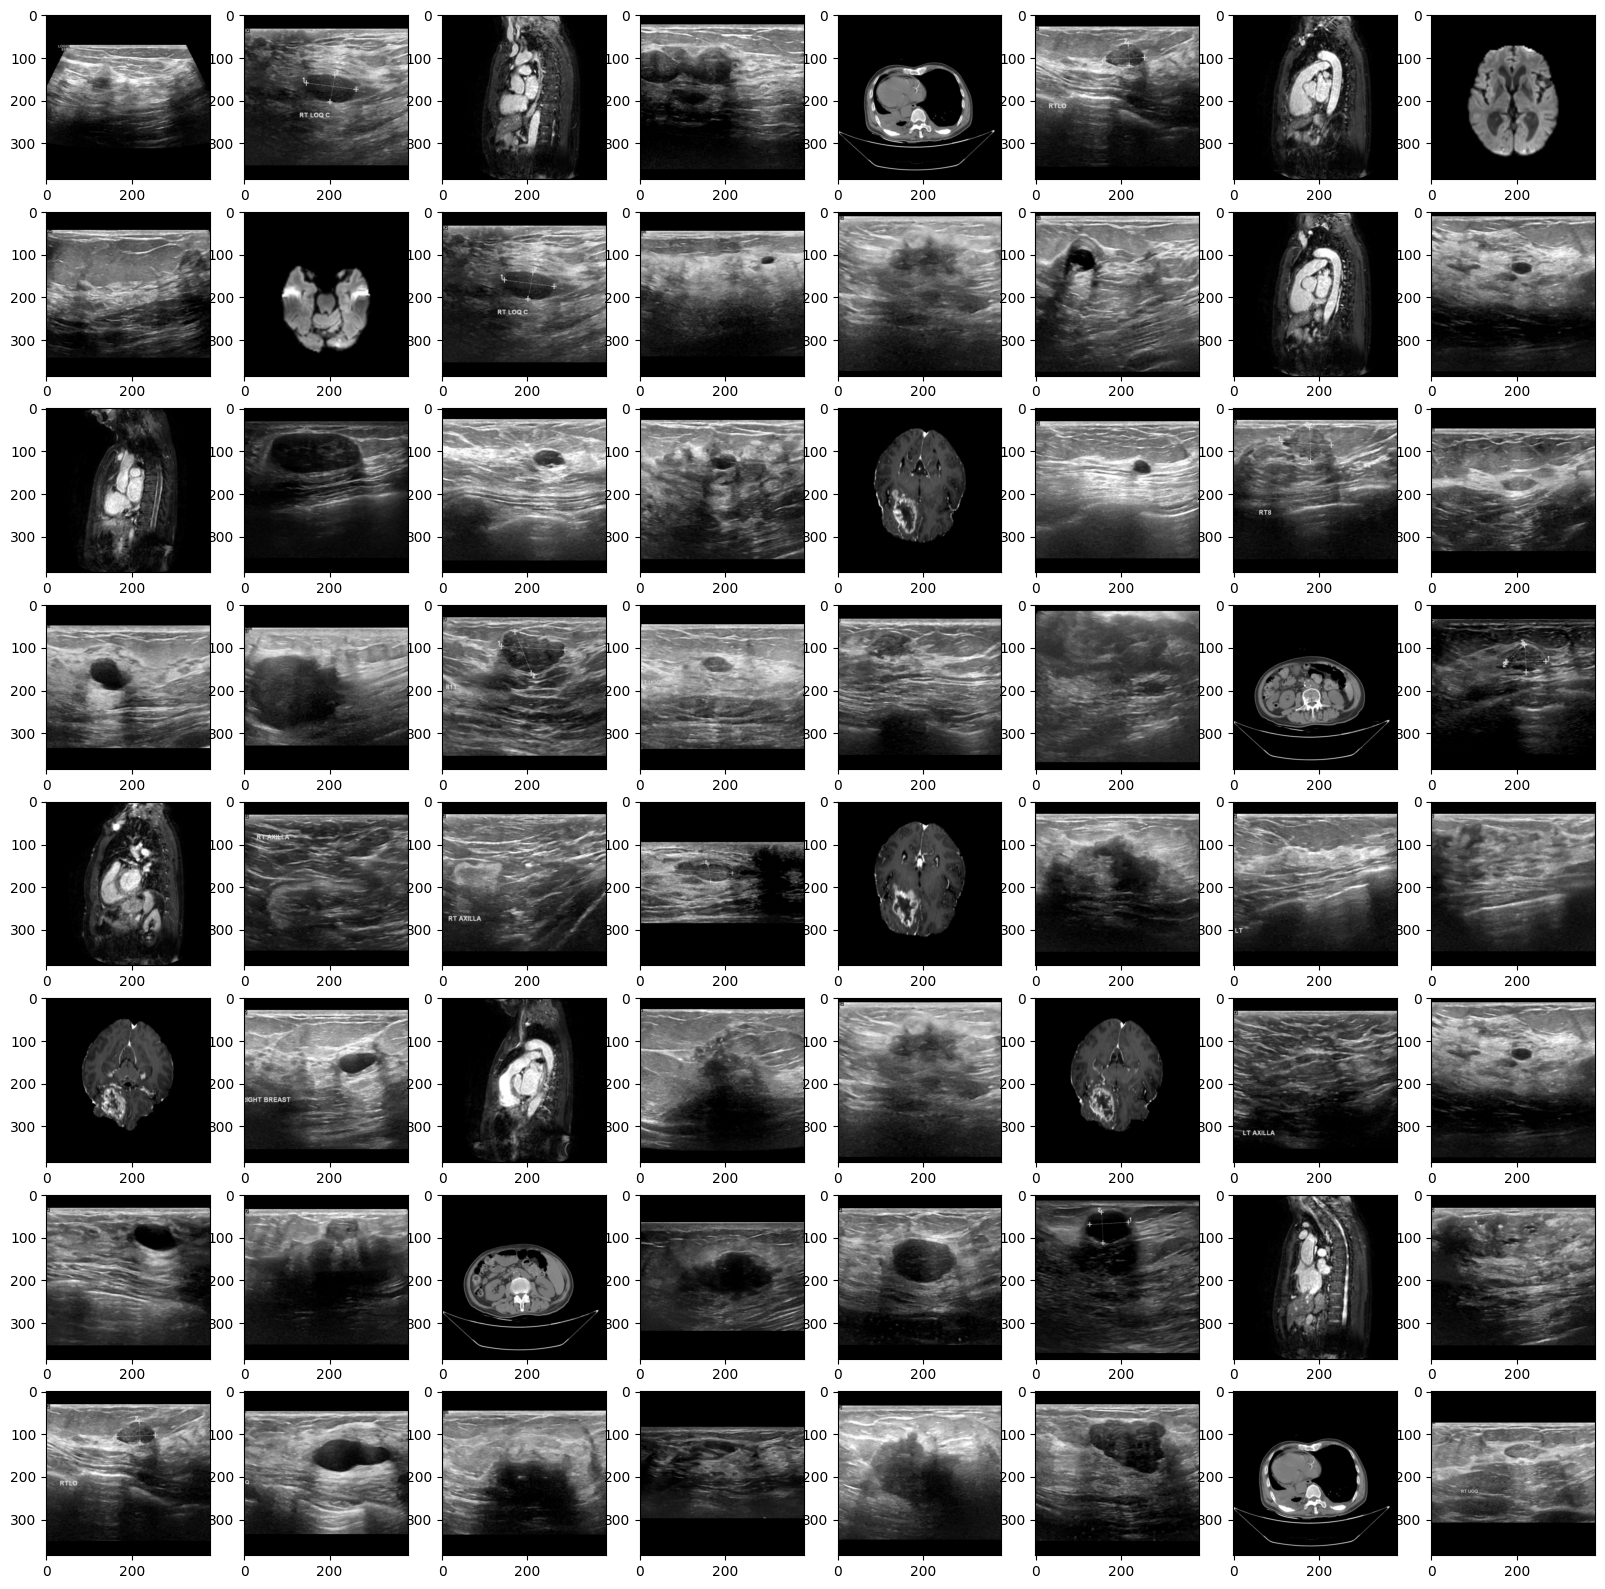

In [11]:
for img in ds.take(1):
    img = img
fix, axes = plt.subplots(8,8, figsize = (20,20))
axes = axes.flatten()
for i, ax in zip(img, axes):
    ax.imshow(i)
plt.show()